# ASTR 596: FDS Homework 5: Hunting for Exoplanets (Due April 1 at Noon)


### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg" width="500">


### But is there a system like our own Solar system with 8 planets (sorry Pluto)? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with the techniques in class. 


### To get and analyze the Kepler data, you'll need the `lightkurve` package

> `python -m pip install lightkurve --upgrade`

### I've included some code to get the light curve, clean it and remove the NaNs, and some outliers (you can judge the wisdom of strong outlier removal when you are hunting for planets), and bin the light curve a little bit in time.


<hr>

#### Hints:


* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html), in particular [this one](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html)

* once you get to a periodogram with `lightkurve`, `find_peaks` in `scipy` can help identify the exoplanet peaks

* You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next. This isn't strictly necessary if you do the previous steps well, but can be helpful. The tutorials page has a demo.

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
import numpy as np
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import find_peaks, find_peaks_cwt

In [2]:
### RUN THIS
lcfs = lk.search_lightcurve('Kepler-90', mission='Kepler').download_all()[:12]

In [3]:
### RUN THIS
def squelch_rednoise(lc):
    corrected_lc = lc.remove_outliers(sigma_upper=10, sigma_lower=10).normalize().flatten(window_length=101)
    return corrected_lc

In [4]:
### RUN THIS - it will take a while.
stitched_lc = lcfs.stitch(corrector_func=squelch_rednoise)

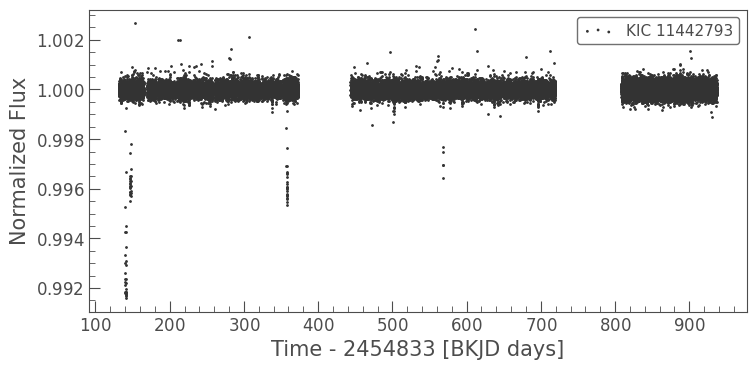

In [5]:
clc = stitched_lc.remove_nans().bin(time_bin_size=15*u.min)
clc.scatter();

#### This is the data we'll deal with

# Q1. First, calculate the periodogram using lightkurve. Use the `bls` method. Look for planets between 50 and 500 day periods with a grid spacing of 0.01d - this is coarse. Use `scipy.signal.find_peaks` to identify peaks in the periodogram. Remember to exclude any peaks arising from the Earth's revolution. Plot the periodogram and highlight the peak locations. (25 pts)


<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

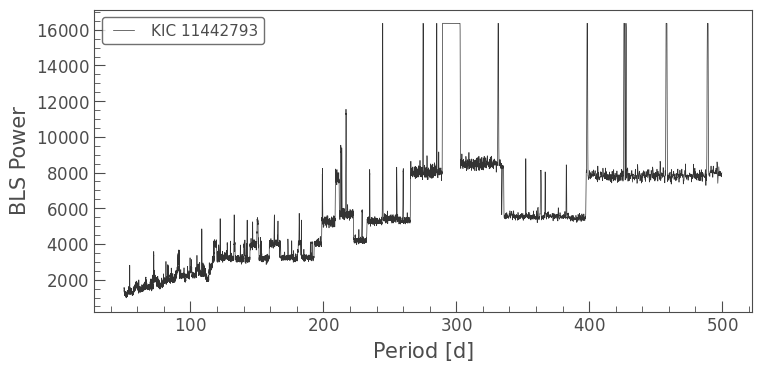

In [6]:
# YOUR CODE HERE

pg = clc.to_periodogram(method='bls', minimum_period=50, maximum_period=500)
pg.plot()

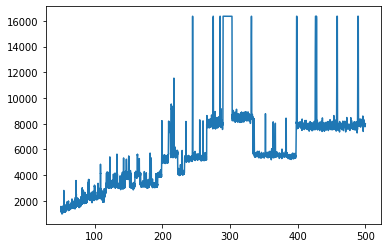

In [16]:
plt.plot(pg.period, pg.power)

In [181]:
# use find peaks 
    # if very near even multiples of 1 ie 50, 51 -  not 50.04 then disregard
    # otherwise use hline with some with and alpha to highlight the peaks of interest
        # might be easier to make a second list of interesting ones so can sort later

# remove stuff near 1 yr 
idx_e = np.where(np.isclose(pg.period.value, u.yr.to(u.d), rtol=1e-3))[0]
periods = np.delete(pg.period.value, idx_e)
powers = np.delete(pg.power.value, idx_e)

# get the peaks
idx_p = find_peaks(powers, prominence=1500)[0] # get the indices of the peaks
peak_p = periods[idx_p]
peak_powers = powers[idx_p]

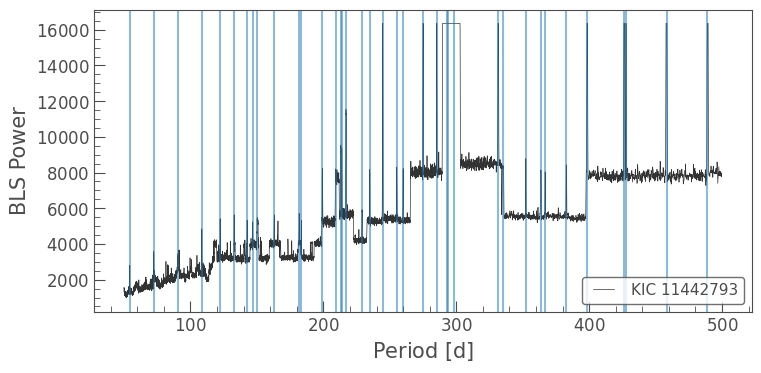

In [182]:
ax = pg.plot()

for p in peak_p:
    ax.axvline(x=p, alpha=0.5)

# Q2. a. The periodogram function from lightkurve can also get a transit time and peak power using `periodogram.transit_time` and `periodogram.power` - you'll want both. Get a sorted list of candidate periods, and print it sorted by peak power. (10 pts)

In [183]:
# YOUR CODE HERE
# tt = pg.transit_time()
# power = pg.power
# 
# for interesting periods used sorted and lambda to sort by power by zipping them into a list of tuples

periods_power = list(zip(peak_p, peak_powers)) # zip the value together
sorted_p = sorted(periods_power, key=lambda x: x[1], reverse=True) # sort by power
peak_p, peak_powers = list(zip(*sorted_p))
peak_p # print the periods, now sorted by power

(293.26527262150694,
 293.66353402730033,
 298.2539436472655,
 244.610568092651,
 398.58258961946666,
 274.9912895156367,
 285.3325302490699,
 331.5610966281482,
 426.4895568143944,
 458.43653587066933,
 489.01990586894726,
 427.75502825028724,
 217.0323670950481,
 213.11107206689263,
 213.8487015016674,
 352.3614263432153,
 382.8236080518859,
 334.9852686959757,
 255.19522419548196,
 199.32750413244324,
 260.1587353506107,
 209.2614370811505,
 234.86897764768307,
 363.82296081739014,
 366.90953464163266,
 229.2256648961389,
 181.8141708685331,
 132.8658334907938,
 163.15761205419054,
 150.3048747321275,
 122.3189205710535,
 183.4595054846155,
 142.65344433967093,
 146.784966808565,
 108.49969181014113,
 90.91461892573308,
 72.31736935471845,
 54.26614332520215)

# Q2. b. Next sort the list of periods from longest to shorted. Check if each period has a period in your list that is either 1/2 or 1/3 the same value. If it is, exclude it. If not keep it. Select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d. (15 pts)

In [200]:
# YOUR CODE HERE
# sort the tuples accending
sp = sorted(list(zip(list(peak_p), list(peak_powers))), reverse=True)
#sort_periods, sort_powers = list(zip(*sorted_p))

remove_i = []
for i, (p_curr, _) in enumerate(sp):
    for j, (p, _) in enumerate(sp[i+1:]):
        if np.isclose(p_curr / 2, p, atol=0.01) or np.isclose(p_curr / 3, p, atol=0.01):
            print(p_curr / 2, p_curr / 3,p )
            remove_i.append(i+1+j)
sp = np.delete(sp, remove_i, axis=0) # axis to avoid flattening

229.21826793533467 152.81217862355643 229.2256648961389
199.29129480973333 132.8608632064889 132.8658334907938
183.45476732081633 122.30317821387756 183.4595054846155
90.90708543426655 60.60472362284437 90.91461892573308


array([[  489.01990587, 16358.83650245],
       [  458.43653587, 16358.83650245],
       [  427.75502825, 16358.83650245],
       [  426.48955681, 16358.83650245],
       [  398.58258962, 16358.83650245],
       [  382.82360805,  8431.65803292],
       [  366.90953464,  8038.10307883],
       [  363.82296082,  8125.94215101],
       [  352.36142634,  8776.56309583],
       [  334.9852687 ,  8416.12065834],
       [  331.56109663, 16358.83650245],
       [  298.25394365, 16358.83650245],
       [  293.66353403, 16358.83650245],
       [  293.26527262, 16358.83650245],
       [  285.33253025, 16358.83650245],
       [  274.99128952, 16358.83650245],
       [  260.15873535,  8222.98294272],
       [  255.1952242 ,  8297.51405953],
       [  244.61056809, 16358.83650245],
       [  234.86897765,  8172.19674074],
       [  217.0323671 , 11543.22231307],
       [  213.8487015 ,  9380.95161915],
       [  213.11107207,  9532.20395653],
       [  209.26143708,  8199.49957553],
       [  199.32

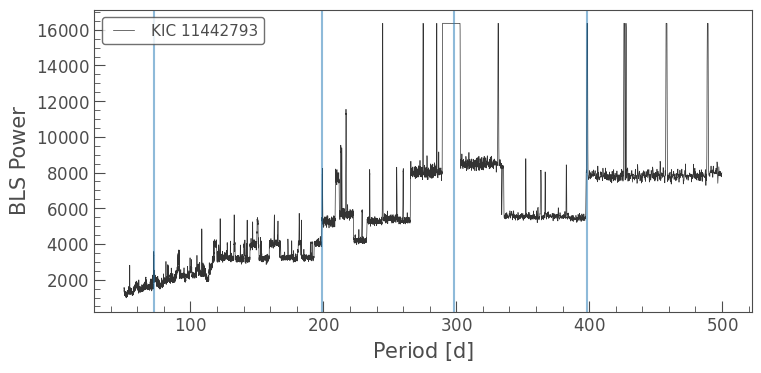

In [202]:
best_p = []

limits = [0, 100, 200, 300, 400]
for i in range(4):
    best = 0
    for (period, power) in sp:
        # between limits and better than the current best
        if period > limits[i] and period < limits[i+1] and period > best:
            best = period
    best_p.append(best)

ax = pg.plot()
for p in best_p:
    ax.axvline(x=p, alpha=0.5)

# Q3. Select each peak period from the coarse grid in Q2.b. and then use lightkurve algorithm to refine the period within +/- 5 days, and get the best period. (25 pts)

`period` contains 498562 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


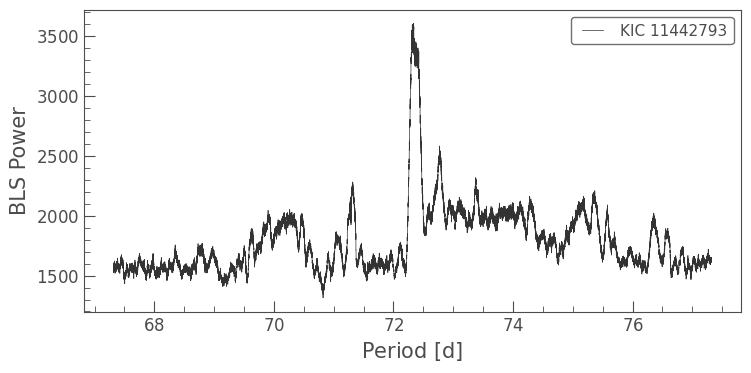

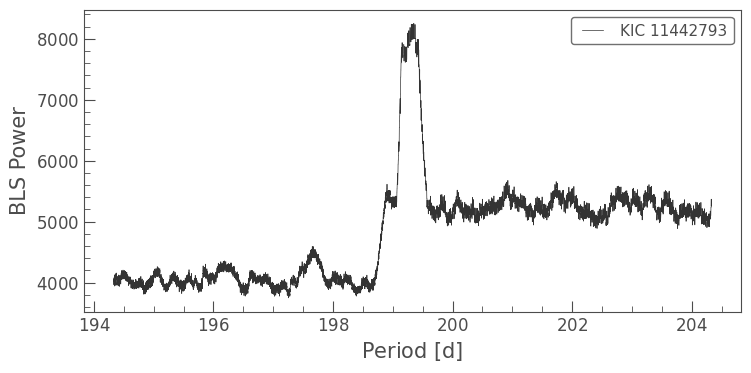

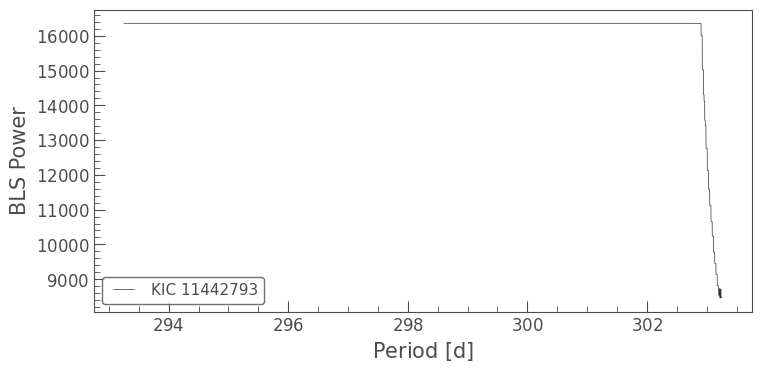

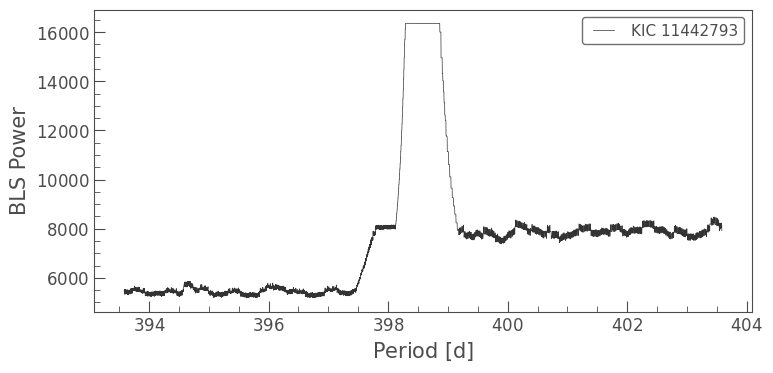

In [205]:
# YOUR CODE HERE
    # repeat to_periodgram but with narrower min and max and finer than 0.01d
    # set up kwarg dicts for each of the 4 periods to investiage
    # ideally since this is so narrow, there shouldnt be another strong peak - should be clear
refined_period = []
for p in best_p:
    pg = clc.to_periodogram(method='bls', minimum_period=p-5, maximum_period=p+5, frequency_factor=0.05)
    refined_period.append(pg.period_at_max_power)
    pg.plot()

In [209]:
print(refined_period)
print(best_p)

[<Quantity 72.33405275 d>, <Quantity 199.34879805 d>, <Quantity 293.25394365 d>, <Quantity 398.28915265 d>]
[72.31736935471845, 199.32750413244324, 298.2539436472655, 398.58258961946666]


# Q4. Use lightkurve.fold to plot the folded light curve for each of the best periods in Q3. (25 pts)

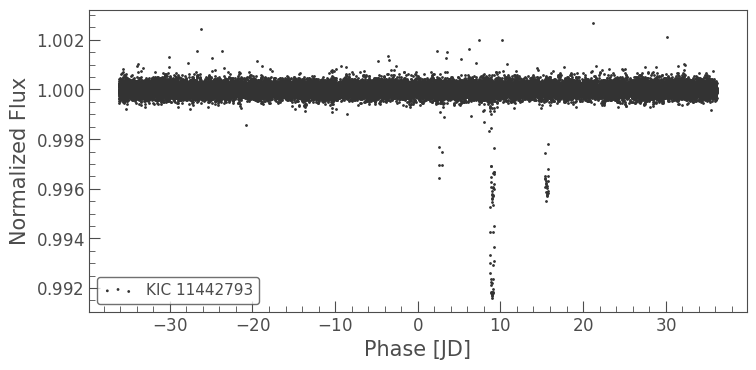

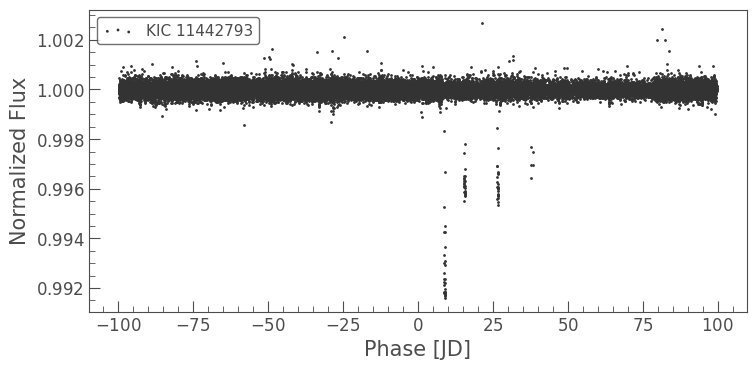

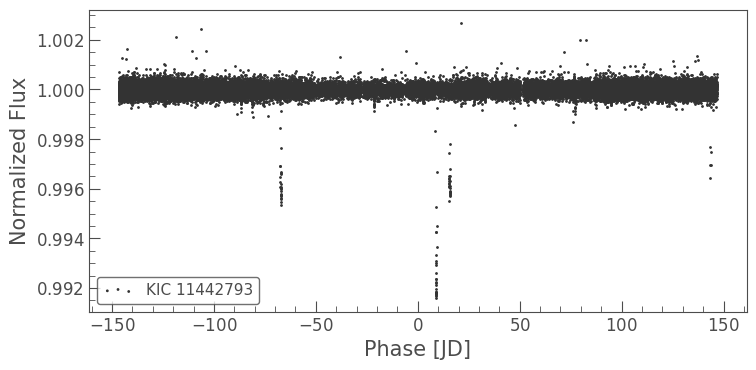

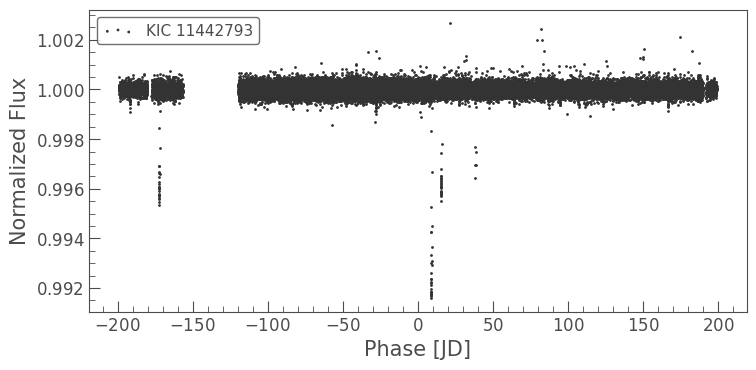

In [212]:
# YOUR CODE HERE
for period in refined_period:
    clc.fold(period).scatter()